In [1]:
# Import libraries:
import matplotlib.pyplot as plt
import numpy as np

import deepxde as dde
from deepxde.backend import tf


Using backend: tensorflow.compat.v1



Instructions for updating:
non-resource variables are not supported in the long term



In [3]:
def heat_eq_exact_solution(x, t, a, L, n):
    """
    Returns the exact solution for a given x and t (for sinusoidal initial conditions).
    
    Parameters
    ----------
    x : np.ndarray
    t : np.ndarray
    """
    
    return np.exp(-(n**2*np.pi**2*a*t)/(L**2))*np.sin(n*np.pi*x/L)

def gen_exact_solution(x_range = (0, 1), t_range = (0, 1), x_dim = 200, t_dim = 200, a = 0.4, n = 1):
    
    """
    Generates exact solution for the heat equation for the given values of x and t.
    """
    
    # Bounds of 'x' and 't':
    t_min, t_max = t_range
    x_min, x_max = x_range

    # Create tensors:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    usol = np.zeros((x_dim, t_dim)).reshape(x_dim, t_dim)

    # Obtain the value of the exact solution for each generated point:
    L = x_max - x_min
    for i in range(x_dim):
        for j in range(t_dim):
            usol[i][j] = heat_eq_exact_solution(x[i],t[j], a, L, n)


    # Save solution:
    np.savez('heat_eq_data', x=x, t=t, usol=usol)
    data = np.load('heat_eq_data.npz')

    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = usol.T.flatten()[:, None]
    
    return X, y

def gen_testdata():
    """
    Import and preprocess the dataset with the exact solution.
    """
    
    # # Load the data:
    data = np.load('heat_eq_data.npz')
    
    # Obtain the values for t, x, and the excat solution:
    t, x, exact = data["t"], data["x"], data["usol"].T
    
    # Process the data and flatten it out (like labels and features):
    xx, tt = np.meshgrid(x, t)
    X = np.vstack((np.ravel(xx), np.ravel(tt))).T
    y = exact.flatten()[:, None]
    
    return X, y



In this code we will solve the heat equation using PINN implemented with the DeepXDE library.

The equation is as follows:

$\frac{\partial u}{\partial t} = \alpha \nabla^2 u\;$ .

Where $\nabla^2$ is the laplacian differential operator, $\alpha$ is the thermal diffusivity constant and $u$ is the function (temperature) we want to approximate.

In a unidimensional case we have:

$\frac{\partial u(x, t)}{\partial t}$ = $\alpha \frac{\partial^2u(x,t)}{{\partial x}^2}\;$, $\;\;\;\; x \in [0, 1]\;$, $\;\;\;\; t \in [0, 1]\;$.

With Dirichlet boundary conditions 

$u(0, t) = u(1, t) = 0\;$ , 

and periodic (sinoidal) initial conditions:

$u(x, 0) = sin(n\pi x/L)\;$, $\;\;\;\; 0 < x < L\;$, $\;\;\;\; n = 1, 2, ...\;.$

This setup is a common problem in many differential equations textbooks and can be physically interpreted as the variation of temperature in a uniform and unidimensional bar over time. Here, the constant $\alpha$ is the thermal diffusivity (a property of the material that the bar is made) and $L$ is the lenght of the bar.



In [4]:
# Problem parameters:
a = 0.4 # Thermal diffusivity
L = 1 # Length of the bar
n = 1 # Frequency of the sinusoidal initial conditions

# Generate a dataset with the exact solution (if you dont have one):
# gen_exact_solution()

# Solve the equation:
# main()

def pde(x, y):
    """
    Expresses the PDE residual of the heat equation.        
    """
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t - a*dy_xx

# Computational geometry:
geom = dde.geometry.Interval(0, L)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

# Initial and boundary conditions:
heat_offset = 0.0
bc = dde.DirichletBC(geomtime, lambda x: heat_offset, lambda _, on_boundary: on_boundary)
ic = dde.IC(
    geomtime, lambda x: np.sin(n*np.pi*x[:, 0:1]/L) + heat_offset, lambda _, on_initial: on_initial
    )

# Define the PDE problem and configurations of the network:
data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=200, num_boundary=10, num_initial=10, num_test=500
)

# original
# net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")

model = dde.Model(data, net)

# Build and train the model:
model.compile("adam", lr=1e-3)
model.train(epochs=20000)
model.compile("L-BFGS")
losshistory, train_state = model.train()

was it here
Compiling model...
Building feed-forward neural network...
'build' took 0.028135 s

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

'compile' took 0.188483 s



/Users/radian/miniforge3/envs/mlp/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+202=202. 
  warnings.warn("The balance properties of Sobol' points require "
/Users/radian/miniforge3/envs/mlp/lib/python3.8/site-packages/skopt/sampler/sobol.py:246: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+12=12. 
  warnings.warn("The balance properties of Sobol' points require "
/Users/radian/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/legacy_tf_layers/core.py:236: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/Users/radian/miniforge3/envs/mlp/lib/python3.8/site-packages/keras/engine/base_layer_v1.py:1676: UserWarning: `layer

Initializing variables...
Training model...



2021-12-07 19:10:31.352948: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Step      Train loss                        Test loss                         Test metric
0         [1.97e-01, 6.46e-02, 4.73e-01]    [1.96e-01, 6.46e-02, 4.73e-01]    []  


2021-12-07 19:10:31.912163: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


1000      [1.13e-03, 2.54e-04, 1.82e-04]    [5.95e-04, 2.54e-04, 1.82e-04]    []  
2000      [1.97e-04, 2.67e-05, 5.70e-06]    [1.45e-04, 2.67e-05, 5.70e-06]    []  
3000      [9.01e-05, 1.73e-05, 4.24e-06]    [6.41e-05, 1.73e-05, 4.24e-06]    []  
4000      [5.38e-05, 1.16e-05, 2.60e-06]    [3.52e-05, 1.16e-05, 2.60e-06]    []  
5000      [3.80e-05, 9.61e-06, 3.03e-06]    [2.60e-05, 9.61e-06, 3.03e-06]    []  
6000      [3.64e-05, 1.33e-05, 6.80e-06]    [2.82e-05, 1.33e-05, 6.80e-06]    []  
7000      [4.47e-05, 5.61e-06, 6.49e-06]    [2.79e-05, 5.61e-06, 6.49e-06]    []  
8000      [1.87e-05, 4.60e-06, 1.27e-06]    [1.17e-05, 4.60e-06, 1.27e-06]    []  
9000      [6.20e-05, 3.34e-05, 2.02e-05]    [4.94e-05, 3.34e-05, 2.02e-05]    []  
10000     [1.36e-05, 2.94e-06, 9.36e-07]    [8.04e-06, 2.94e-06, 9.36e-07]    []  
11000     [2.07e-05, 8.43e-06, 4.93e-06]    [1.55e-05, 8.43e-06, 4.93e-06]    []  
12000     [1.04e-05, 2.05e-06, 7.11e-07]    [5.82e-06, 2.05e-06, 7.11e-07]    []  
1300

2021-12-07 19:13:04.304039: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-07 19:13:04.319777: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-07 19:13:04.322270: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-07 19:13:04.411230: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-12-07 19:13:04.443380: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Optimization terminated with:
  Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  Objective function value: 0.000001
  Number of iterations: 481
  Number of functions evaluations: 533
20533     [5.92e-07, 6.36e-08, 1.60e-08]    [6.56e-07, 6.36e-08, 1.60e-08]    []  

Best model at step 20533:
  train loss: 6.72e-07
  test loss: 7.36e-07
  test metric: []

'train' took 5.095886 s



2021-12-07 19:13:09.366330: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


(40000, 2)
(40000, 1)
bc_points shape (20, 2)
train_next_batch shape (240, 2)


2021-12-07 20:15:37.398340: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


Mean residual: 0.00063705066
L2 relative error: 0.0005873414880613352


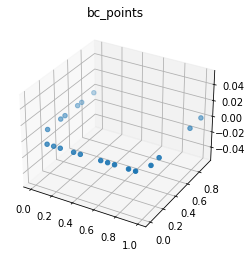

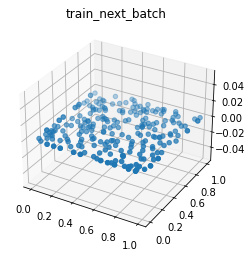

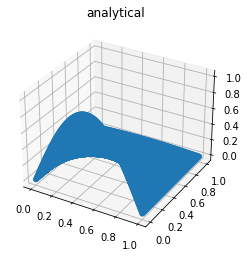

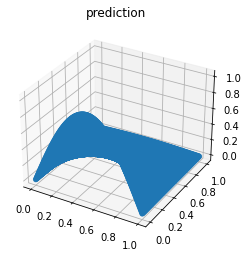

In [8]:
X_test, y_true = gen_exact_solution(
    x_range=(0,L),
    t_range= (0, 1),
    x_dim=200,
    t_dim=200,
    a = a,
    n = n)

print(X_test.shape)
print(y_true.shape)

# X_train = data.train_points()
X_train = data.bc_points()
# X_train, _, _ = data.train_next_batch()
print("bc_points shape", X_train.shape)

train_fig = plt.figure()
train_ax = train_fig.add_subplot(projection='3d')
train_ax.scatter(X_train[:, 0], X_train[:, 1])
train_ax.title.set_text("bc_points")

# aX_train = data.train_points()
# aX_train = data.bc_points()
aX_train, _, _ = data.train_next_batch()
print("train_next_batch shape", aX_train.shape)

train_fig = plt.figure()
train_ax = train_fig.add_subplot(projection='3d')
train_ax.scatter(aX_train[:, 0], aX_train[:, 1])
train_ax.title.set_text("train_next_batch")

# Analytical test solution
analytical_figure = plt.figure()
ax = analytical_figure.add_subplot(projection='3d')
ax.scatter(X_test[:, 0], X_test[:, 1], y_true[:, 0])
ax.title.set_text("analytical")

# Neural network test solution
# Plot/print the results
# dde.saveplot(losshistory, train_state, issave=True, isplot=True)
y_pred = model.predict(X_test)
predict_fig = plt.figure()
ay = predict_fig.add_subplot(projection = '3d')
ay.scatter(X_test[:, 0], X_test[:, 1], y_pred[:, 0])
ay.title.set_text("prediction")

f = model.predict(X_test, operator=pde)

print("Mean residual:", np.mean(np.absolute(f)))
print("L2 relative error:", dde.metrics.l2_relative_error(y_true, y_pred))
np.savetxt("test.dat", np.hstack((X_test, y_true, y_pred)))
